# Crop Identification and Disease Recognition
## Image Classification with a Convolutional Neural Network
#### Analysis by Ben Geissel

In [27]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D , Dropout, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from PIL.Image import core as image
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.cloud import storage
import image_processing

In [2]:
# Run through image files and determine if any are the wrong shape
# Count images by crop/disease type
data_path = 'PlantVillage-Dataset/raw_image_data/color'
diff_shape_count = 0
img_count = 0
leaf_type_img_count = 0
leaf_type_img_count_dict = {}
for folder in os.listdir(data_path):
    for image in os.listdir('%s/%s' % (data_path, folder)):
        img_loc = '%s/%s/%s' % (data_path, folder, image)
        img = Image.open(img_loc)
        arr = np.array(img)
        img_shape = arr.shape
        img_count += 1
        leaf_type_img_count += 1
        if img_shape != (256, 256, 3):
            diff_shape_count += 1
            print(img_loc)
            print(img_shape)
        else:
            continue
    leaf_type_img_count_dict[folder] = leaf_type_img_count
    leaf_type_img_count = 0
print('Wrong Shape Image Count: %d' % (diff_shape_count))
print('Total Color Image Count: %d' % (img_count))
print()
print('Color Image Count by Class:')
leaf_type_img_count_dict

Wrong Shape Image Count: 0
Image Count: 54304


{'Apple___Apple_scab': 630,
 'Apple___Black_rot': 621,
 'Apple___Cedar_apple_rust': 275,
 'Apple___healthy': 1645,
 'Blueberry___healthy': 1502,
 'Cherry_(including_sour)___Powdery_mildew': 1052,
 'Cherry_(including_sour)___healthy': 854,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513,
 'Corn_(maize)___Common_rust_': 1192,
 'Corn_(maize)___Northern_Leaf_Blight': 985,
 'Corn_(maize)___healthy': 1162,
 'Grape___Black_rot': 1180,
 'Grape___Esca_(Black_Measles)': 1383,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076,
 'Grape___healthy': 423,
 'Orange___Haunglongbing_(Citrus_greening)': 5507,
 'Peach___Bacterial_spot': 2297,
 'Peach___healthy': 360,
 'Pepper,_bell___Bacterial_spot': 997,
 'Pepper,_bell___healthy': 1477,
 'Potato___Early_blight': 1000,
 'Potato___Late_blight': 1000,
 'Potato___healthy': 152,
 'Raspberry___healthy': 371,
 'Soybean___healthy': 5090,
 'Squash___Powdery_mildew': 1835,
 'Strawberry___Leaf_scorch': 1109,
 'Strawberry___healthy': 456,
 'Tomato___Bac

In [3]:
# Define function to convert every image into (256*256*3) array
def image_to_array(image_loc):
    img = Image.open(image_loc)
    arr = np.array(img)
    return arr

In [4]:
# Define function to normalize pixels (0 to 1) of each image (0 to 255 pixel values possible)
def pixel_normalization(img_array):
    img_array = img_array.astype('float32')
    img_array /= 255.0
    return img_array

In [5]:
# Define function to center pixel values based on mean pixel value
def pixel_centering(norm_img_arr):
    mean = norm_img_arr.mean()
    norm_img_arr = norm_img_arr - mean
    return norm_img_arr

In [6]:
# Run through image files and convert to pixel array, normalize, and center
# Add array to larger data array
data_list = []
target_list = []
data_path = 'PlantVillage-Dataset/raw_image_data/color'
for folder in os.listdir(data_path):
    for image in os.listdir('%s/%s' % (data_path, folder)):
        img_loc = '%s/%s/%s' % (data_path, folder, image)
        img_arr = image_processing.image_to_array(img_loc)
        data_list.append(img_arr)
        target_list.append(folder)

In [7]:
# Convert list to array
data_array = np.array(data_list)
target_array = np.array(target_list)

In [8]:
# Normalize Arrays
norm_list = []
for img_array in data_array:
    norm_arr = image_processing.pixel_normalization(img_array)
    norm_list.append(norm_arr)

In [9]:
# Standardize Arrays
standardized_list = []
for norm_arr in norm_list:
    standardized_img_arr = image_processing.pixel_centering(norm_arr)
    standardized_list.append(standardized_img_arr)

In [10]:
# Convert to array
standardized_data_array = np.array(standardized_list)

In [11]:
# Train Test Validation Split - 15% testing data, 15% validation data, 70% training data
X_train, X_test, y_train, y_test = train_test_split(standardized_data_array, target_array,
                                                    test_size = .15, random_state = 14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size = (1 - .7/.85), random_state = 14)

In [12]:
# Define epochs, batch size, and number of classes
batch_size = 100
epochs = 25
n_classes = 38

In [13]:
# Label Encode Target Classes
target_class_list = list(leaf_type_img_count_dict.keys())
le = LabelEncoder()
le.fit(target_class_list)
target_class_int_list = list(le.classes_)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [14]:
# Convert target class vectors to target class binary matrices
y_train = keras.utils.to_categorical(y_train, num_classes = n_classes)
y_val = keras.utils.to_categorical(y_val, num_classes = n_classes)
y_test = keras.utils.to_categorical(y_test, num_classes = n_classes)

In [15]:
# Check to see that GPU is being used
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [16]:
# Create image generator object
img_gen = ImageDataGenerator(width_shift_range = 0.15, height_shift_range = .15, rotation_range = 30, shear_range = .25,
                            zoom_range = .25, horizontal_flip = True)

In [17]:
# Construct convolutional neural network architecture
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D(pool_size = (3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = 'softmax'))

In [18]:
# Compile model and run
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adadelta(),
              metrics = ['accuracy', 'mse'])

model_history = model.fit_generator(img_gen.flow(X_train, y_train, batch_size = batch_size),
                                    validation_data = (X_val, y_val),
                                    steps_per_epoch = len(X_train) // batch_size,
                                    epochs = epochs,
                                    verbose = 1)

Epoch 1/20
434/434 [==============================] - 556s 1s/step - loss: 2.7140 - accuracy: 0.2510 - mse: 0.0226 - val_loss: 1.9682 - val_accuracy: 0.4548 - val_mse: 0.0187
Epoch 2/20
434/434 [==============================] - 560s 1s/step - loss: 1.5960 - accuracy: 0.5363 - mse: 0.0158 - val_loss: 1.3118 - val_accuracy: 0.6308 - val_mse: 0.0136
Epoch 3/20
434/434 [==============================] - 561s 1s/step - loss: 1.0083 - accuracy: 0.6974 - mse: 0.0109 - val_loss: 0.6136 - val_accuracy: 0.8032 - val_mse: 0.0074
Epoch 4/20
434/434 [==============================] - 565s 1s/step - loss: 0.7104 - accuracy: 0.7827 - mse: 0.0081 - val_loss: 0.4669 - val_accuracy: 0.8545 - val_mse: 0.0056
Epoch 5/20
434/434 [==============================] - 565s 1s/step - loss: 0.5482 - accuracy: 0.8301 - mse: 0.0064 - val_loss: 0.4424 - val_accuracy: 0.8647 - val_mse: 0.0053
Epoch 6/20
434/434 [==============================] - 554s 1s/step - loss: 0.4358 - accuracy: 0.8666 - mse: 0.0052 - val_loss

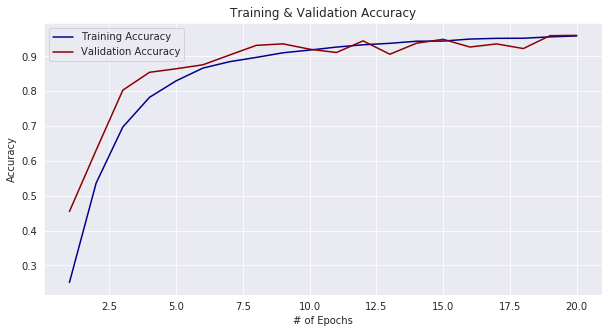

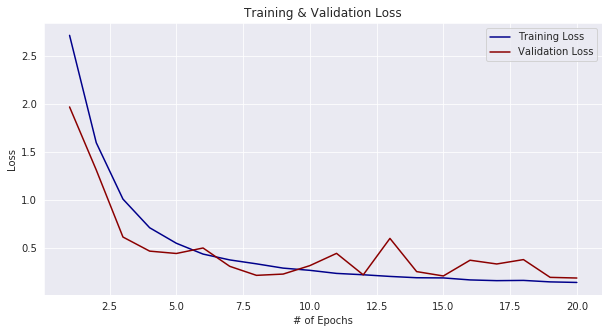

Test loss: 0.18682775751889966
Test accuracy: 0.9605929255485535


In [28]:
# Plotting metrics over epochs
sns.set_style('darkgrid')
model_acc = model_history.history['accuracy']
model_val_acc = model_history.history['val_accuracy']
model_loss = model_history.history['loss']
model_val_loss = model_history.history['val_loss']
model_epochs = range(1, len(model_acc) + 1)
plt.figure(figsize = (10,5))
plt.plot(model_epochs, model_acc, 'darkblue', label = 'Training Accuracy')
plt.plot(model_epochs, model_val_acc, 'darkred', label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend(loc = 'best')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize = (10,5))
plt.plot(model_epochs, model_loss, 'darkblue', label = 'Training Loss')
plt.plot(model_epochs, model_val_loss, 'darkred', label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.legend(loc = 'best')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.show()

# Final Metrics
score = model.evaluate(X_val, y_val, verbose = 0)
print('Validation Loss:', score[0])
print('Validation Accuracy:', score[1])
print()
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

In [21]:
# Saving model for future use
model.save("crop_leaves_disease_model.h5")